In [2568]:

import tganalysis
import os
import emoji
import pandas as pd

paths = ['C:/Users/mk/Downloads/Telegram Desktop/ChatExport_2024-04-20 (2)']

filename = os.path.join('data', paths[0], 'result.json')


Сегодня продолжил анализировать чаты. Нашел более понятную инструкцию как делать culture consensus analysis (CCA), немного доработал (в оригинале используются данные интервью), и реализовал его на основе данных чата кудрявых. Получилось не сразу, но получилось. Судя по анализу в чате есть 1 культура. Я, конечно, ожидал такого результата (как никак 3 месяца его анализирую), но все равно приятно.😊

Я сделал упрощенную версию CCA - на основе факторного анализа (PCA) на уровне участников чата. 

Большую часть дня я экспериментировал с этим анализом - смотрел как результаты меняются, когда я изменяю параметры, изучал результаты и т.п. В итоге я понял, что этот анализ выявляет есть или нет культура даже без моего вмешательства. А еще, приятный побочный эффект - можно извлекать ключевые слова относящиеся к этой культуре (их я могу потом отправлять чатгпт).

Так, поняв, что "оно работает само" я попробовал этот метод на других чатах и нашел еще пару чатов, где он показывает присутствие единых культур - чат для активистов, сохраняющих малоресурсные языки, чат osm-картографов и чат работников пунктов выдачи ВБ. Пока я не изучал эти чаты глубже, но в целом правдоподобно. Все эти чаты имеют особые языки и активную аудиторию, я и без этого метода замечал, что они отличаются от других чатов. 

Есть еще много вопросов, например, возможно, что в более общих чатах CCA не находит одной культуры просто потому, что люди там общаются на много разных тех. Нужно ли это как-то учитывать или просто откинуть такие чаты?

На сегодняшний день, я очень доволен этими промежуточными результатами. Кроме подтверждения цифрами, что у меня на руках есть цифровая культура для анализа, я их нашел еще несколько, так что смогу экспериментировать с ними, сравнивая что получается и что не получается.😊

In [2569]:

from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)
emb = NewsEmbedding()
segmenter = Segmenter()
morph_vocab = MorphVocab()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)


In [2570]:
tg = tganalysis.tg_json_analysis(filename)
data = tg.df
data

{66396: msg(id=66396, type='message', date='2023-10-01T00:08:47', from_name='Aura_ Pirs', from_id='user1206893398', reply_to_message_id=66395, text='Уже объяснили и это печально', words=None, year=2023, month=10, day=1, week=39, weekday=7, hour=0, td_idf=None),
 66397: msg(id=66397, type='message', date='2023-10-01T03:38:19', from_name='Дикие Ягодки', from_id='user972724161', reply_to_message_id=None, text='Купила новую камеру.\n1.  трассер \n2. Веб глазок (новая)', words=None, year=2023, month=10, day=1, week=39, weekday=7, hour=3, td_idf=None),
 66398: msg(id=66398, type='message', date='2023-10-01T03:38:19', from_name='Дикие Ягодки', from_id='user972724161', reply_to_message_id=None, text='', words=None, year=2023, month=10, day=1, week=39, weekday=7, hour=3, td_idf=None),
 66399: msg(id=66399, type='message', date='2023-10-01T03:41:18', from_name='Дикие Ягодки', from_id='user972724161', reply_to_message_id=None, text='Извис', words=None, year=2023, month=10, day=1, week=39, weekday

In [2571]:
# data[522845].text
# text = data[522835].text


docs = list()

for dp in data:
    text = data[dp].text
    text = emoji.replace_emoji(text, lambda a,_:f".{a}. ")
    text = text.replace(') ', "). ")
    text = text.replace('\n', "\n. ")
    text = '. '.join([a.capitalize() for a in text.split('. ')])
    try:
        doc = Doc(text)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)
        doc.parse_syntax(syntax_parser)
        for token in doc.tokens:
            token.lemmatize(morph_vocab)
        docs.append({'id': dp, 'from_name': data[dp].from_id, 'doc': doc})
    except:
        pass
    




In [2572]:
# text = 'Мне алоэ плоховато распутывает и не очень делал волосы скользкими, хотя обычно у меня такой проблемы нет, в итоге получался очень большой расход'
# text = emoji.replace_emoji(text, lambda a,_:f".{a}. ")
# text = text.replace(') ', "). ")
# text = text.replace('\n', "\n. ")
# text = '. '.join([a.capitalize() for a in text.split('. ')])
# doc = Doc(text)
# doc.segment(segmenter)
# doc.tag_morph(morph_tagger)
# doc.parse_syntax(syntax_parser)
# for token in doc.tokens:
#     token.lemmatize(morph_vocab)
# doc.tokens

In [2573]:
roots_all = []
for doc_index, doc in enumerate(docs):
    for sent_index, sent in enumerate(doc['doc'].sents):
        roots = dict()
        for token in sent.tokens:
            if (token.rel == 'root') and (token.pos == 'VERB'):
                if not token.id in roots:
                    roots[token.id] = {'doc_index': doc_index, 'sent_index': sent_index}
                roots[token.id]['root'] = token
            if token.rel == 'obj':
                try:
                    root_token = sent.tokens[int(token.head_id[2:])-1]
                except:
                    root_token = sent.tokens[int(token.head_id[3:])-1]
                if not (root_token.rel == 'root' and root_token.pos == 'VERB'):
                    continue
                if not token.head_id in roots:
                    roots[token.head_id] = {'doc_index': doc_index, 'sent_index': sent_index}
                roots[token.head_id]['obj'] = token
            if token.rel == 'nsubj':
                try:
                    root_token = sent.tokens[int(token.head_id[2:])-1]
                except:
                    root_token = sent.tokens[int(token.head_id[3:])-1]
                if not (root_token.rel == 'root' and root_token.pos == 'VERB'):
                    continue
                if not token.head_id in roots:
                    roots[token.head_id] = {'doc_index': doc_index, 'sent_index': sent_index}
                roots[token.head_id]['nsubj'] = token
            if token.rel == 'advmod':
                try:
                    root_token = sent.tokens[int(token.head_id[2:])-1]
                except:
                    root_token = sent.tokens[int(token.head_id[3:])-1]
                if not (root_token.rel == 'root' and root_token.pos == 'VERB'):
                    continue
                if not token.head_id in roots:
                    roots[token.head_id] = {'doc_index': doc_index, 'sent_index': sent_index}
                roots[token.head_id]['advmod'] = token
        if roots:
            roots_all.append(roots)                
        # print(roots)
        # break


In [2594]:
df = list()
for roots in roots_all:
    for root_id, root in roots.items():
        from_name = docs[root['doc_index']]['from_name']
        msg_id = docs[root['doc_index']]['id']
        d = {'from_name': from_name, 'msg_id': msg_id}
        try:
            d['advmod'] = root['advmod'].lemma
        except:
            pass
        try:
            d['root'] = root['root'].lemma
        except:
            pass
        try:
            d['nsubj'] = root['nsubj'].lemma
        except:
            pass
        try:
            d['obj'] = root['obj'].lemma
        except:
            pass
        df.append(d)
    # break
# doc[roots]

df = pd.DataFrame(df)
df_orig = df.copy()

# df


In [2595]:
names = df[['from_name', 'msg_id']].groupby('from_name').count()['msg_id']
names = names[names > 10]
# names

In [2596]:
df = df.fillna('').groupby(['from_name', 'nsubj', 'advmod', 'root', 'obj']).count().reset_index().set_index('from_name')
# df

In [2597]:
df = df[df.index.isin(names.index)]
df.loc[:,'msg_id'] = df['msg_id']/names
# df.sort_values('msg_id', ascending=False).head(30)

C:\Users\mk\AppData\Local\Temp\ipykernel_13148\147400006.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.04       0.04       0.04       ... 0.09090909 0.09090909 0.09090909]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,'msg_id'] = df['msg_id']/names


In [2598]:
param = 'obj'


df[[param, 'msg_id']].groupby(param).count().sort_values('msg_id', ascending=False)

,msg_id
obj,
,10016
товар,176
что,139
коробка,81
это,80
...,...
низкий,1
никакой,1
нить,1


In [2599]:

nsubjs = df[[param, 'msg_id']].groupby(param).count().query('msg_id < 300 & msg_id > 1').sort_values('msg_id', ascending=False)
# .query('msg_id < 400 & msg_id > 3')
nsubjs


,msg_id
obj,
товар,176
что,139
коробка,81
это,80
весь,76
...,...
платный,2
плюс,2
поздравление,2


In [2600]:
df = df[df[param].isin(nsubjs.index)]
df

,nsubj,advmod,root,obj,msg_id
from_name,,,,,
channel1690502818,,,плизнуть,я,0.040000
channel1690502818,,ранний,переводить,баланс,0.040000
channel1690502818,+,не,показывать,вещь,0.040000
channel1690502818,я,не,найти,способ,0.040000
channel1717788282,компенсация,,выложить,отчет,0.066667
...,...,...,...,...,...
user993299571,,,заказать,возврат,0.037037
user993299571,итак,,снять,сумма,0.037037
user994911025,,,искать,контакт,0.090909


In [2601]:
users_corr = df.pivot_table(index=param, columns='from_name', values='msg_id', aggfunc='sum').fillna(0).corr()
# users_corr = users_corr > 0
# users_corr = users_corr.corr()
# users_corr# = users_corr[users_corr.index]

<Axes: xlabel='from_name', ylabel='from_name'>

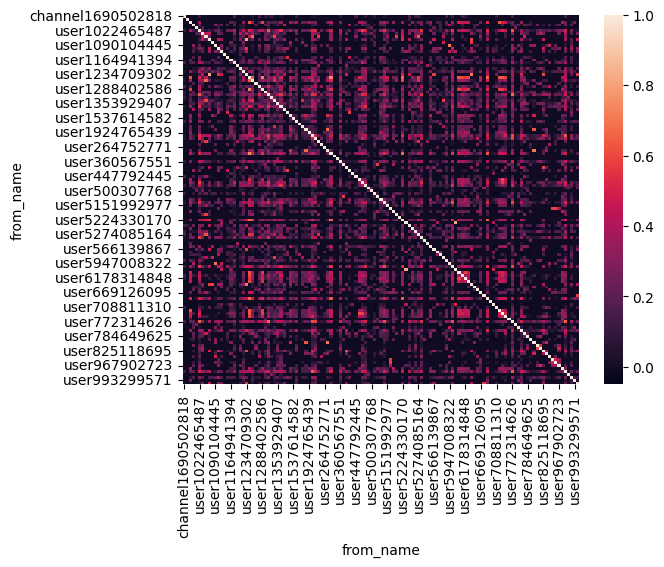

In [2602]:
import matplotlib.pyplot as plt

import seaborn as sns
plt.figure()
c= users_corr
sns.heatmap(c)

2.6478654463762306 len= 127 <0: 29


,PC1
variable,
user1276843711,0.211134
user347904627,0.191061
user6872229826,0.190232
user1022465487,0.175062
user5224330170,0.173562
...,...
user5422906734,-0.014621
user1809109555,-0.015240
user6719428068,-0.015897


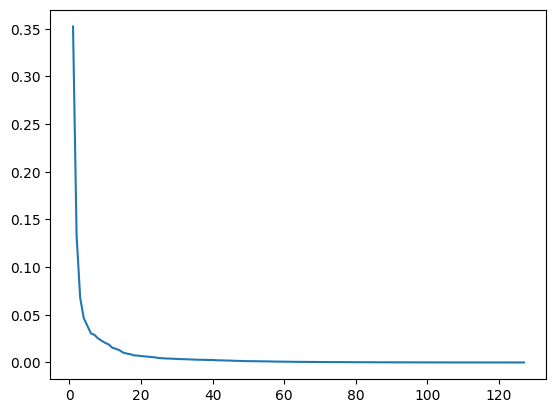

In [2603]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_out = PCA().fit(users_corr)

ev = pca_out.explained_variance_ratio_
plt.plot(range(1,users_corr.shape[1]+1),ev)

loadings = pca_out.components_
num_pc = len(users_corr)
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = users_corr.columns.values
loadings_df = loadings_df.set_index('variable').sort_values('PC1', ascending=False)
# loadings_df['PC1'].to_list()
print(ev[0]/ev[1], 'len=', len(loadings_df.loc[:,'PC1']), '<0:', sum(loadings_df.loc[:,'PC1'] < 0))
loadings_df.loc[:,['PC1']]



In [2604]:
users_corr.loc[loadings_df.index.values[0], loadings_df.index.values[1]]

0.7444243852275487

In [2605]:
df.loc[loadings_df.index.values[-1], ['msg_id', param]].groupby(param).sum().sort_values('msg_id', ascending=False).head(30)

KeyError: 'obj'

In [2606]:
from collections import Counter
words = Counter()
for i in range(int(sum(loadings_df.loc[:,'PC1'] > 0)/2)):
    try:
        a = df_orig.set_index('from_name').loc[loadings_df.index.values[i], ['msg_id', param]].groupby(param).sum().sort_values('msg_id', ascending=False).index.to_list()
        # a = df.loc[loadings_df.index.values[i], ['msg_id', param]].groupby(param).sum().sort_values('msg_id', ascending=False).index.to_list()
    except:
        pass
    words.update(a)

# [k for k, w in words.items() if w > 7]
pd.Series(words).sort_values(ascending=False).head(25)


товар      47
что        26
коробка    25
видео      21
возврат    19
деньга     17
я          17
это        17
ничто      17
весь       17
он         16
они        15
брак       14
штраф      14
пакет      14
вопрос     13
вещь       12
она        12
номер      12
вы         12
шк         12
подмена    12
пара       11
пункт      11
тот        11
dtype: int64

In [ ]:
# df.groupby(['nsubj', 'advmod', 'root','obj']).agg(['mean', 'count']).sort_values(('msg_id', 'mean'), ascending=False).to_clipboard(decimal=',')

In [ ]:
df[['msg_id', 'root', 'obj', 'nsubj', 'advmod']].groupby(['nsubj','advmod', 'root', 'obj',  ]).count().reset_index().sort_values('msg_id', ascending=False)
#.to_clipboard()
# .head(30)

,nsubj,advmod,root,obj,msg_id
1450,кто,,мочь,,17
1996,нпос,,работать,,10
3433,товар,,прийти,,8
4042,это,,значить,,7
3242,ссылка,,быть,,7
...,...,...,...,...,...
1431,крючок,,приклеить,,1
1432,крючок,там,думать,,1
1433,кто,,боксбрать,подключать,1
1434,кто,,брать,запись,1


In [ ]:
texts = pd.DataFrame(data).transpose()[[3, 4, 0, 6]].rename(columns={3:'from_name', 4:'from_id', 0: 'msg_id', 6:'text'}).set_index('msg_id')


In [ ]:
df_orig.query('nsubj == "водоросль" & root == "получаться"')
df_orig.query('nsubj == "диффузор" & root == "мочь"')
df_orig.query('nsubj == "банк"').groupby('root').count().sort_values('msg_id', ascending=False)

,from_name,msg_id,advmod,obj,nsubj
root,,,,,


In [ ]:
msg_ids = df_orig.query('nsubj == "банк"  & root == "быть"')['msg_id']
msg_ids

Series([], Name: msg_id, dtype: int64)

In [ ]:
texts[texts.index.isin(msg_ids)]['text'].to_clipboard()

In [ ]:
verb = 'мочь'
df.pivot_table(index='from_name', columns='root', values='msg_id', aggfunc='count')[[verb]].dropna().sort_values(verb, ascending=False)

c:\Users\mk\miniforge3\lib\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


root,мочь
from_name,
user772314626,35.0
user5099957108,21.0
user972724161,12.0
user1022465487,11.0
user528478588,10.0
...,...
user5212101073,1.0
user5262055690,1.0
user5422906734,1.0
